In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 United Kingdom Research and Innovation
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by:    Gemma Fardell (UKRI-STFC)
#                   Laura Murgatroyd (UKRI-STFC)
                  

# Exercise 03 - Where is my reader?
### 2D laboratory micro-CT, fan-beam with no reader

We don't have readers for every system so you might need to read in your data and create a geometry by hand.

This exercise walks through the steps needed to load in a 2D fan-beam sinogram stored as a single tiff image; create the matching geometry and finally reconstruct it using FDK. The data was acquired on a Nikon system but here we only read the centre slice and do not provide a reader for `xtek2dCT` files.

Learning objectives are:
- Load and investigate a dataset stored as a tiff using `TIFFStackReader`
- Create the CIL geometry using `AcquisitionGeometry.Create_Cone2D`
- Combinine the data and geometry to form an `AcquisitionData`
- Find the Centre of rotation to complete the data geometry description
- Compute the reconstruction using CIL's `FDK`

The sample is a plastic tube with a diameter of 25mm filled with uniform Soda-Lime Glass (SiO2-Na2O) beads of diameters 2.5mm (with standard deviation 0.1mm). 
This example requires the dataset `SparseBeads_B12_L1.zip` from https://zenodo.org/record/290117 :

- https://zenodo.org/record/290117/files/SparseBeads_B12_L1.zip


If running locally please download the data and update the filepath in the `filename` variable below:

In [2]:
filename = "/mnt/materials/CIL/SparseBeads_B12_L1/CentreSlice/Sinograms"

In [3]:
from cil.io import TIFFStackReader
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.processors import CentreOfRotationCorrector
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
import numpy as np
import matplotlib.pyplot as plt

# Read in your data

## Exercise A: Tiff to numpy array

1. Load the 2D fan-beam sinogram, using the `TIFFStackReader`
2. Use `show2D` to visualise your data
3. Look at the data type and shape

In [4]:
data_original = ...

**If you are stuck uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time**

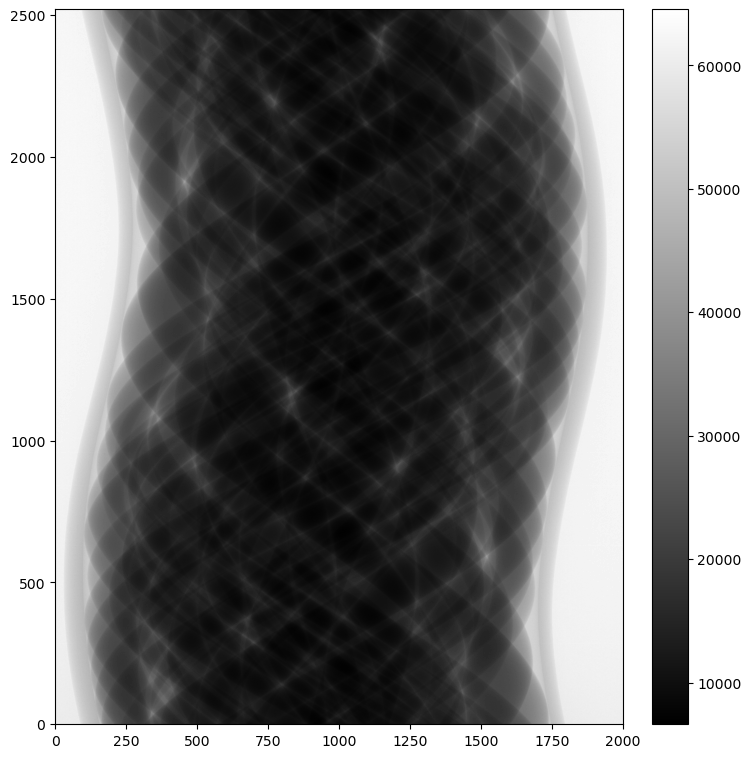

In [5]:
# %load './snippets/03_exA.py'
# create the TIFF reader by passing the directory containing the files
reader = TIFFStackReader(file_name=filename, dtype=np.float32)

# read in file, and return a numpy array containing the data
data_original = reader.read()

# use show2D to visualise the sinogram
show2D(data_original)


In [6]:
print("Array stored as:",type(data_original))
print("Array shape:\t",data_original.shape)
print("Array contents:\t",data_original.dtype)

Array stored as: <class 'numpy.ndarray'>
Array shape:	 (2520, 2000)
Array contents:	 float32


# Understand your data

Let us look at a histogram of our data. 

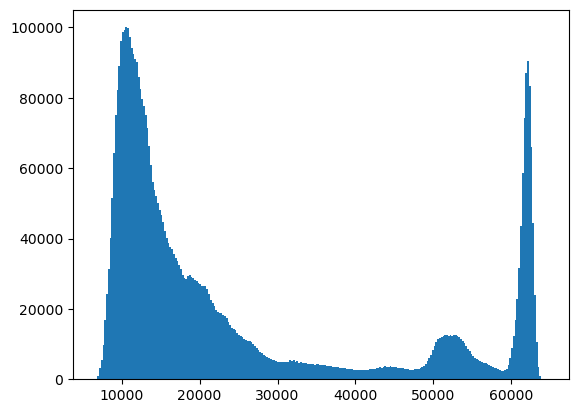

In [7]:
plt.hist(data_original.ravel(), bins=256)
plt.show()

We should notice that the data is X-ray transmission data. We can see that the background peak has the highest value.

The background peak is not at 1. When the data was saved as a tiff it was pre-scaled by 60000 by the scanner and stored as `unsigned char` which have integer values 0 - 65535. We can see the white level of 60000 in the `xtek2dct` file so we use this to normalise the data.


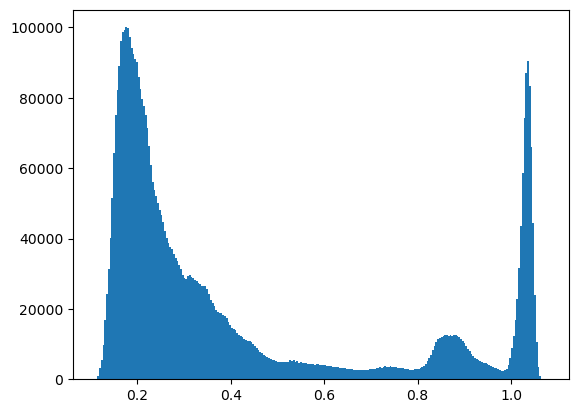

In [8]:
data_normalised = data_original / 60000
plt.hist(data_normalised.ravel(), bins=256)
plt.show()

And now we use Beer-Lambert's law to convert from X-ray transmission data to X-ray absorption data

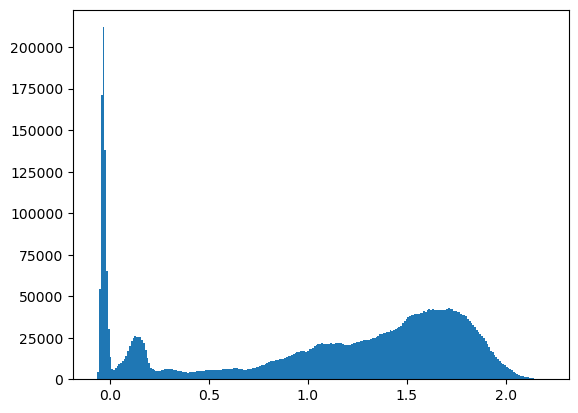

In [9]:
data_absorption = -np.log(data_normalised)
plt.hist(data_absorption.ravel(), bins=256)
plt.show()

You may notice the background has a small negative attenuation. This is unphysical in an ideal system however it is often caused by to systematic errors in the scan. Potentially scatter caused by the object can raise the background value in the background of the scan but is not present in the flat-field image. Or latent image in the scintillator fades between the flat-field collection and the scan. We must be careful not to clip these negative values and bias the reconstruction.

# Create the geometry

As well as the data itself, we need to create the geometric metadata as an `AcquisitionGeometry` object.

We start by populating the information we know from the data. For parallel beam data this might be sufficient.

## Exercise B: Use the data
From the data set, extract the number of projections, the number of pixels and the order of the 'horizontal' and 'angle' axes:


In [10]:
number_of_projections = ...
number_of_pixels = ...
axis_labels = [..., ...]

Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time:

In [11]:
# %load './snippets/03_exB.py'
# we can get the number of projections and number of pixels from the shape of the data
number_of_projections = data_normalised.shape[0]
number_of_pixels = data_normalised.shape[1]

# the data is stored as a stack of detector images, we use the cil labels for the axes
axis_labels = ['angle','horizontal']

## Exercise C: Create the geometry

Now we create the CIL `AcquisitionGeometry` object using the method `AcquisitionGeometry.create_Cone2D`

You will have to set the position of the source, rotation axis (object) and detector. Look at the [documentation of `create_Cone2D`](https://tomographicimaging.github.io/CIL/nightly/framework.html#cone2d-geometry-fanbeam) as well as the notebook [00_CIL_geometry](../00_CIL_geometry.ipynb) to help you.

1. Create a fan-beam geometry using the `AcquisitionGeometry.create_Cone2D`
2. Configure the angles of the data with `set_angles`
3. Configure the number and size of the detector pixels with `set_panel`
4. Configure the order of the data axes using `set_labels`
2. Use the `show_geometry` method to display the scan set up visually.

Here we give you the information from the scanner metadata, you can find these values in the `xtek2dct`

Have a go at creating the geometry and see how it looks when you reconstruct the data with it. It might take a few attempts to get it right but if you are struggling you can uncomment the snippet and load an example solution.

In [12]:
#What we know from the scanner
source_to_detector_distance = 1400.207
source_to_object_distance = 121.932
pixel_size = 0.2
angles = np.linspace(start=0, stop=360, num=number_of_projections, endpoint=False)

In [13]:
geometry = ...

# show_geometry(geometry)

Uncomment the following line and run the cell to see the solution, to run the lines you'll need to run the cell a second time:

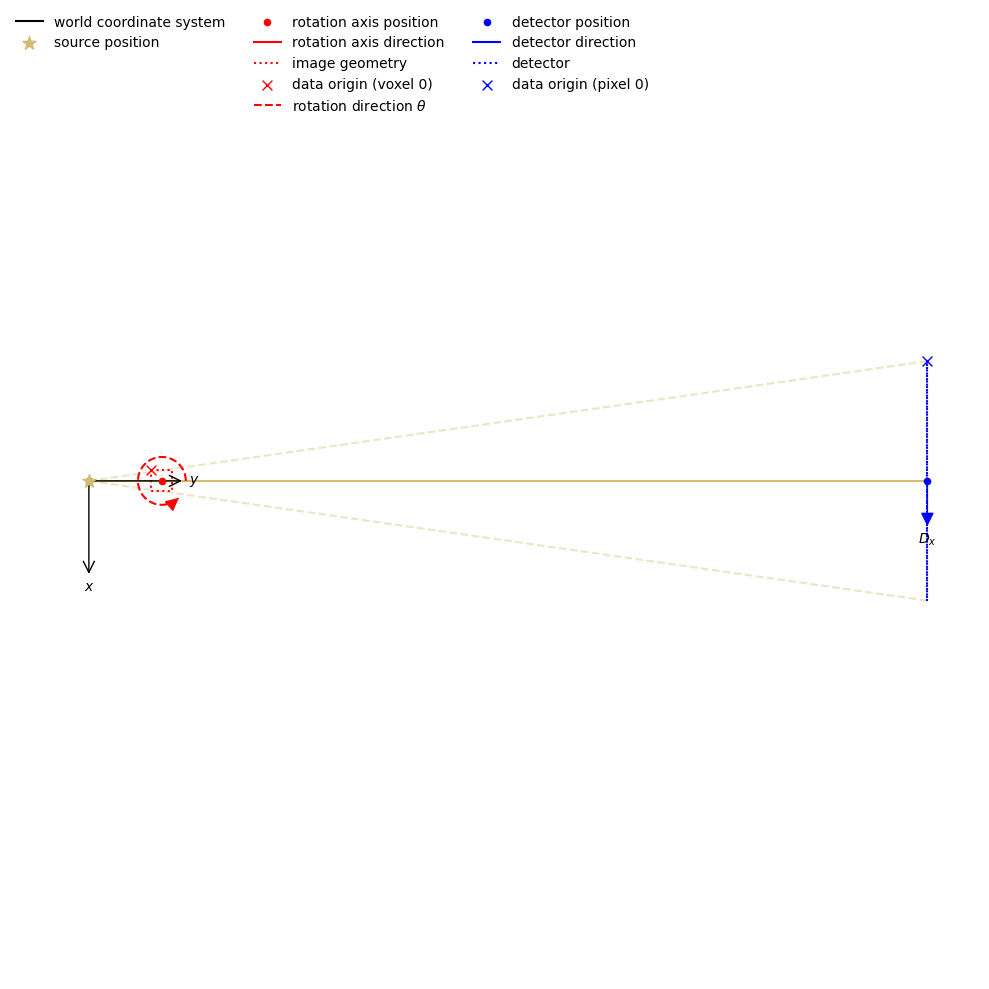

In [14]:
# %load './snippets/03_exC.py'
# create the geometry using the `Cone2D` convenience method.
# These are relative positions of each so you may have set it up differently to this answer but it doesn't make it wrong.
geometry = AcquisitionGeometry.create_Cone2D(source_position=[0,0],
                                             detector_position=[0,source_to_detector_distance],
                                             rotation_axis_position=[0,source_to_object_distance])

# set the angles, remembering to specify the units
geometry.set_angles(angles, angle_unit='degree')

# set the detector shape and size
geometry.set_panel(number_of_pixels,pixel_size)

# set the order of the data
geometry.set_labels(axis_labels)

# display your geometry, does it look like a feasible CT scan set up?
show_geometry(geometry)

# Create the `AcquisitionData`

Now we have our data `data_absorption` stored as a numpy array and `geometry` containing the description of our data, we can use both to create an `AcquisitionData` that can be used by CIL.

Here we make a copy of the original data with `deep_copy=True`. For a large data set you may want this to use your existing numpy array with `deep_copy=False`

In [15]:
acquisition_data = AcquisitionData(data_absorption, deep_copy=True, geometry=geometry)

# Reconstruct with FDK 

Now we will try to reconstruct your `AcquisitionData` using CIL's `recon.FDK`. This uses CIL to filter the projections, and then calls the backprojector from `TIGRE`.

In [16]:
reconC = FDK(acquisition_data).run()

FDK recon

Input Data:
	angle: 2520
	horizontal: 2000

Reconstruction Volume:
	horizontal_y: 2000
	horizontal_x: 2000

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False



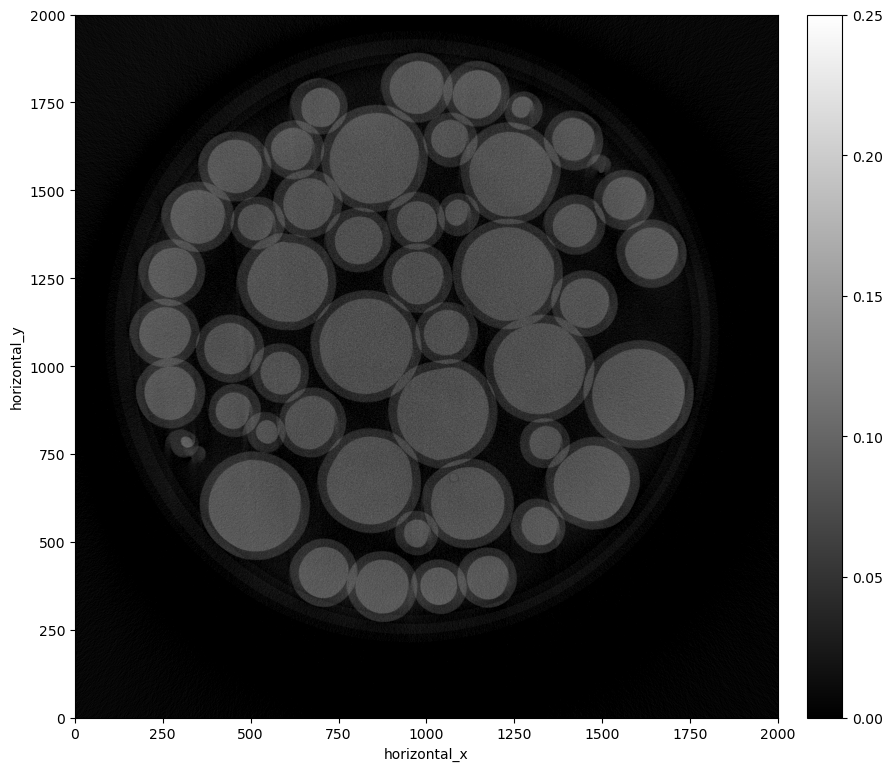

In [17]:
show2D(reconC, fix_range=(0,0.25))

If your geometry was right, you will now have a reconstruction that looks like this. If something went wrong, then go back to **Exercise C** and have another go at setting up your geometry.

![example FDK](./images/03_output.png)

# Centre of rotation offset

We are nearly there but the double edges show our geometry is still not quite right. These are typical centre of rotation artefacts for a 360degree scan. We can update the geometry by hand until we find the right value. 

### Exercise D: Fix the centre of rotation offset
Use `set_centre_of_rotation` on your geometry to update the value and reconstruct your data. Try values between -5 and 5 until you obtain a nice-looking reconstruction.

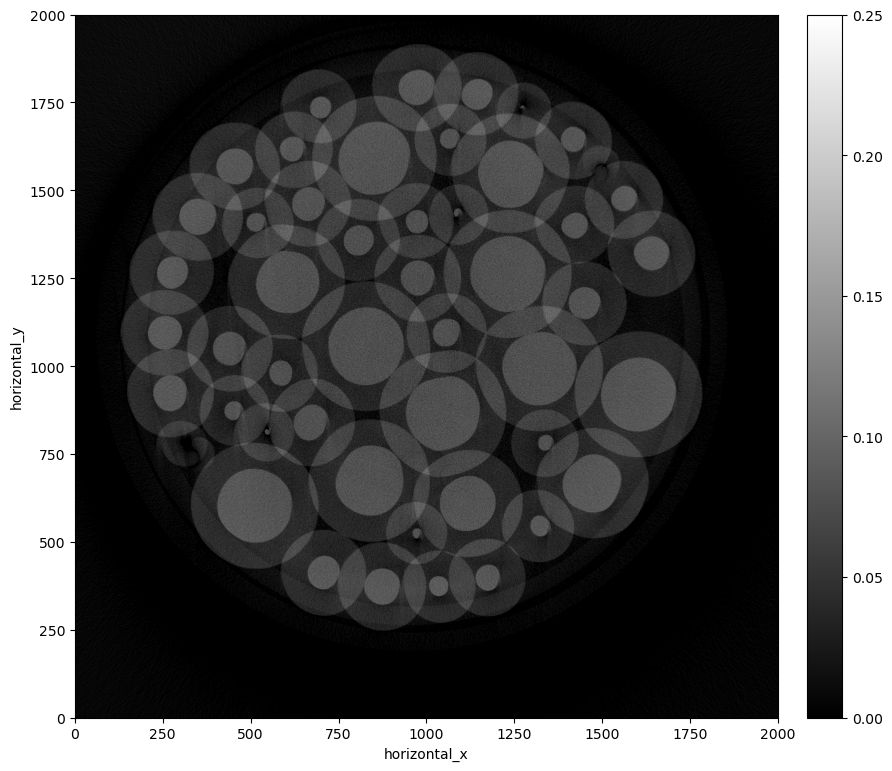

In [18]:
# set the offset between -5 and 5
offset = 5

#apply it to your geometry
acquisition_data.geometry.set_centre_of_rotation(offset,distance_units='default')

#reconstruct your data with the updated geometry
reconD = FDK(acquisition_data).run(verbose=0)
show2D(reconD, fix_range=(0,0.25))

Often we can use CIL's `CentreOfRotationCorrector` algorithms to find the centre of rotation offset to subpixel accuracy.

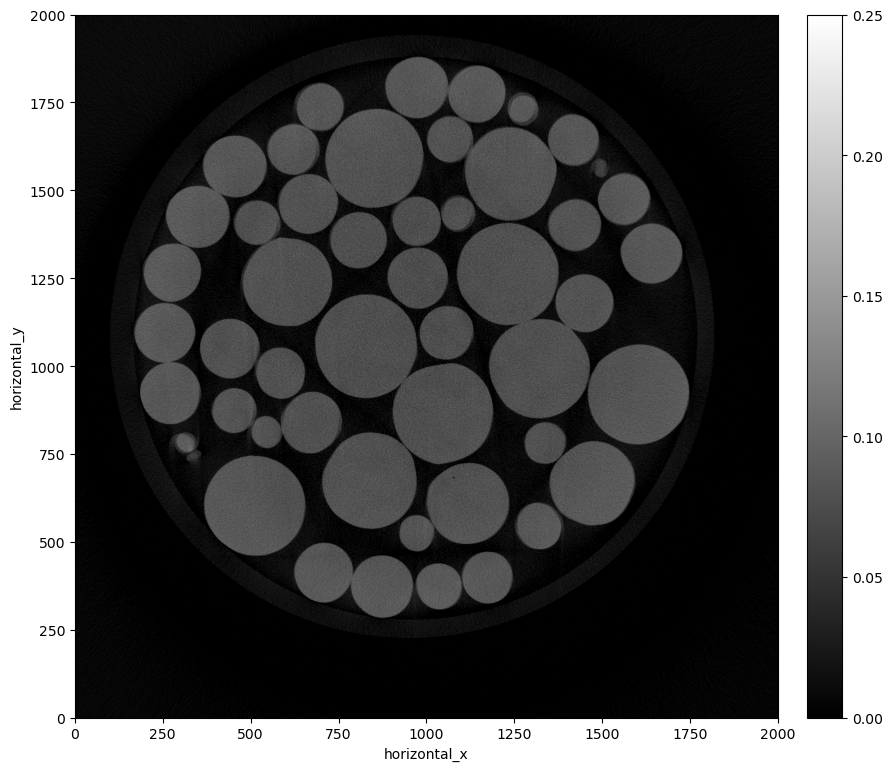

In [19]:
processor = CentreOfRotationCorrector.image_sharpness()
processor.set_input(acquisition_data)
centred_data = processor.get_output()

recon_centred = FDK(centred_data).run(verbose=0)
show2D(recon_centred, fix_range=(0,0.25))

In [20]:
print(centred_data.geometry.get_centre_of_rotation())

{'offset': (-2.416481220552027, 'units distance'), 'angle': (0.0, 'radian')}


Some common mistakes when you create your geometry by hand include:
 - The rotation direction. This might not simply be how the turntable looks to turn (if you can see it!), the detector origin may be interpreted differently and appear to flip your data.
 - The definition of 0 degree. Look at `show_geometry` you can see that as default CIL defines 0degree in the positive Y direction. You might need to add 180 degrees to your angles, or swap the detector and source positions along the y axis.
 - The pixel size - CIL expects your pixel size in the same units as you defined your system geometry. In this example we used $mm$. This means our reconstruction has values of $mm^{-1}$

## Exercise E: Try the common mistakes

Go back to **Exercise C** and try setting the geometry up wrong to see how the reconstruction looks.

 - What if the rotation is in the opposite direction? Set the `angles` to `-angles`
 - What if there's a 180 degree offset in your angles?
 - What if you define your angles in the wrong units? Set the units to `radian`
 - What if your pixel size is wrong? How does the cone angle affect the reconstruction?
 - CIL's geometry assumes the centre ray of the beam in the positive Y direction. You can configure this along the X axis instead but you will need to update the direction of the detector and redefine your angles accordingly.

